# Method 4: MTL with multiple heads

In [1]:
import test
import importlib
importlib.reload(test)
from test import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [5]:
fun()

Hello World


### Load data comments
- import data from clean file into pandas (data small enough to save all in memory)
- load into a tensor for x, targets and migrate to gpu ideally and use in data loader
- check mapping function in Method 1 and 2
- then add tokenizer

In [195]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('===============')
print('Device:', device)
print('===============')
torch.backends.cudnn.benchmark = True

Device: cpu


### Initializing random multi-task data

In [219]:
# generate random data vector of dim 10
n_t1 = 100
dim = 10
# Task 1: 3 classes {0, 1, 2}
x_t1 = torch.rand(n_t1, dim)
y_t1 = (x_t1.sum(dim=1)/3).floor()[:,None]

# Task 2: 2 classes {0, 1}
n_t2 = 80
x_t2 = torch.rand(n_t2, dim)
y_t2 = (x_t2.mean(dim=1) * 2).floor()[:,None]


assert y_t1.shape == (n_t1,1) and y_t2.shape == (n_t2,1), "y_t1 and y_t2 should be column vectors"

# create a Dataset object from the data
train_data_t1 = TensorDataset(x_t1, y_t1)
train_data_t2 = TensorDataset(x_t2, y_t2)
# wrap into DataLoader
train_dataloader_t1 = DataLoader(train_data_t1, batch_size=20, shuffle=True)
train_dataloader_t2 = DataLoader(train_data_t2, batch_size=20, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)





In [220]:
next(iter(train_dataloader_t1))

[tensor([[0.0367, 0.0717, 0.7306, 0.3167, 0.4394, 0.1374, 0.7035, 0.7189, 0.8907,
          0.2355],
         [0.7454, 0.7535, 0.1385, 0.3990, 0.4403, 0.4287, 0.7190, 0.7529, 0.8424,
          0.9916],
         [0.1055, 0.9786, 0.3669, 0.4567, 0.5582, 0.6739, 0.9362, 0.0764, 0.3545,
          0.3518],
         [0.5783, 0.6674, 0.2956, 0.7628, 0.5285, 0.3001, 0.2825, 0.7233, 0.9189,
          0.3850],
         [0.0749, 0.9781, 0.2161, 0.8046, 0.4939, 0.1386, 0.4381, 0.8156, 0.1917,
          0.1964],
         [0.2288, 0.3672, 0.6858, 0.6499, 0.1161, 0.3619, 0.1500, 0.1705, 0.3651,
          0.5206],
         [0.6678, 0.2509, 0.1645, 0.7738, 0.1540, 0.2388, 0.7867, 0.8994, 0.6025,
          0.2089],
         [0.0068, 0.4285, 0.5188, 0.8847, 0.2876, 0.4000, 0.5048, 0.8600, 0.3160,
          0.6533],
         [0.9717, 0.7975, 0.9889, 0.2402, 0.4842, 0.7976, 0.4748, 0.1207, 0.8505,
          0.5367],
         [0.8142, 0.2981, 0.8752, 0.9478, 0.6608, 0.0810, 0.0946, 0.9227, 0.2046,
         

In [166]:
y_t1.shape, y_t1

(torch.Size([100]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         2., 0., 1., 1., 1., 2., 1., 2., 1., 0., 1., 1., 1., 2., 1., 1., 1., 1.,
         1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 2.]))

In [165]:
y_t2.shape, y_t2

(torch.Size([100]),
 tensor([1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 0., 0., 1., 0., 1.]))

### MTL mutli-head network

In [47]:
# when we have multiple tasks performed on the same input data
class MTL(nn.Module):
    def __init__(self, dim, h_dim, t1_out, t2_out):
        super().__init__()
        # joint hidden layers
        self.BERT = nn.Linear(dim, h_dim)

        # task-specific classification heads
        self.cf_t1 = nn.Linear(h_dim, t1_out)
        self.cf_t2 = nn.Linear(h_dim, t2_out)

    def forward(self, x):
        # joint hidden state
        h = F.relu(self.BERT(x))
        # task 1
        p_t1 = F.softmax(self.cf_t1(h), dim=1)
        # task 2
        p_t2 = F.softmax(self.cf_t2(h), dim=1)
    
        return [p_t1, p_t2]

In [50]:
# when we have multiple tasks performed on different input data
class MTL(nn.Module):
    '''
    returns class probabilities for each task
    '''
    def __init__(self, dim, h_dim, t1_out, t2_out):
        super().__init__()
        # joint hidden layers
        self.BERT = nn.Linear(dim, h_dim)

        # task-specific classification heads
        self.cf_t1 = nn.Linear(h_dim, t1_out)
        self.cf_t2 = nn.Linear(h_dim, t2_out)

    def forward(self, x, task_num=1):
        # joint hidden state
        h = F.relu(self.BERT(x))
        # task 1
        if task_num == 1:
            p_t1 = F.softmax(self.cf_t1(h), dim=1)
            return p_t1
        # task 2
        elif task_num == 2:
            p_t2 = F.softmax(self.cf_t2(h), dim=1)
            return p_t2
        else:
            print("Invalid task number")
            return None

In [143]:
model = MTL(dim, 10, 3, 2)

In [111]:
model.forward(x_t1[0:2], task_num=1)

tensor([[0.4525, 0.3207, 0.2268],
        [0.4499, 0.2992, 0.2509]], grad_fn=<SoftmaxBackward0>)

In [112]:
# cross-entropy loss accepts logits as input and either class label or class probabilities vecoter as target: loss(input, target)
# has an internal softmax
# targets are class indices so {0,1} is valid and {-1,1} is not valid
loss_fn = nn.CrossEntropyLoss()

### Training procedure

In [209]:
model = MTL(dim, 10, 3, 2)
# optimizer: RMSprop as in the paper
# alpha: smoothing constant (default: 0.99)
# eps: term added to the denominator to improve numerical stability (default: 1e-8)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# loss function: cross-entropy
loss_fn = nn.CrossEntropyLoss()

epochs = 10000

for epoch in range(1, epochs+1):
    #mini_batches = 
    #for mini_batch in mini_batches:
    for x_t1_mini, y_t1_mini in train_dataloader_t1:
        # Transfer to GPU
        x_t1_mini, y_t1_mini = x_t1_mini.to(device), y_t1_mini.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # task 1
        # get class probabilities
        p_t1 = model.forward(x_t1_mini, task_num=1)
        # make predictions
        # y_pred_t1 = p_t1.argmax(dim=1).float()
        # compute loss
        loss_t1 = loss_fn(p_t1,y_t1_mini.long().squeeze())

        # task 2
        # get class probabilities
        # p_t2 = model.forward(x_t2, task_num=2)
        # compute loss
        # loss_t2 = loss_fn(p_t2,y_t2.long())

        # total loss
        loss = loss_t1 # + loss_t2

        #loss = Variable(loss, requires_grad = True)

        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()

    # print statistics
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f}")




    

Epoch 1000/10000 | Loss: 0.6547
Epoch 2000/10000 | Loss: 0.6014
Epoch 3000/10000 | Loss: 0.6514
Epoch 4000/10000 | Loss: 0.6014
Epoch 5000/10000 | Loss: 0.6514
Epoch 6000/10000 | Loss: 0.7014
Epoch 7000/10000 | Loss: 0.6014
Epoch 8000/10000 | Loss: 0.7014
Epoch 9000/10000 | Loss: 0.6014
Epoch 10000/10000 | Loss: 0.7514


### Evalutation

In [206]:
# evaluate model accuracy
# predict classes
y_pred_t1 = model(x_t1, task_num=1).argmax(dim=1).float()
y_pred_t2 = model(x_t2, task_num=2).argmax(dim=1).float()

print('===============================')
# task 1
acc_t1 = (y_pred_t1 == y_t1).sum().item()/n
print(f"Task 1 train accuracy: {acc_t1:.4f}")
# task 2
acc_t2 = (y_pred_t2 == y_t2).sum().item()/n
print(f"Task 2 train accuracy: {acc_t2:.4f}")
print('===============================')

Task 1 train accuracy: 83.3400
Task 2 train accuracy: 49.0000


### Confusion matrix

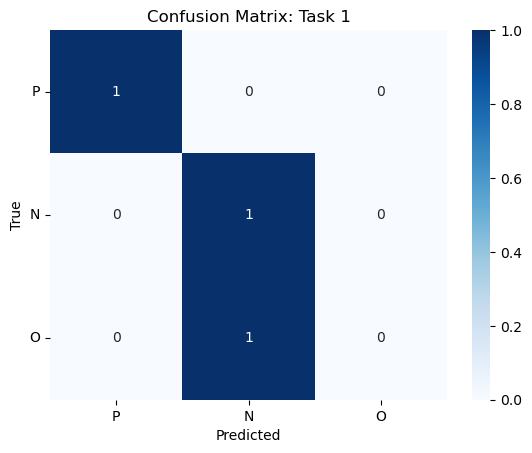

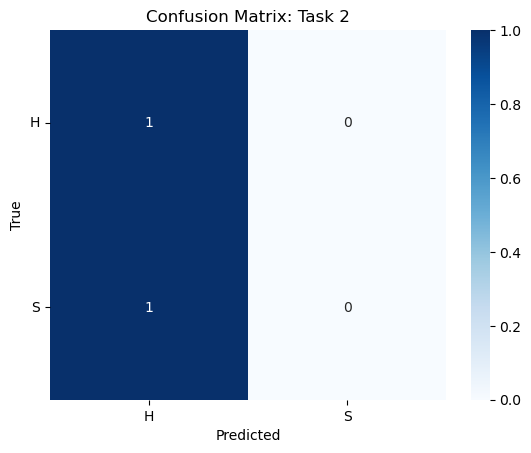

In [207]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y, y_pred, targets, task_num=1):
    cm = confusion_matrix(y, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=targets.values(), yticklabels=targets.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: Task {task_num}')
    plt.yticks(rotation=0)
    plt.show()

targets_t1 = {0: 'P', 1: 'N', 2: 'O'}
targets_t2 = {0: 'H', 1: 'S'}

plot_conf_matrix(y_t1, y_pred_t1, targets_t1, task_num=1)
plot_conf_matrix(y_t2, y_pred_t2, targets_t2, task_num=2)